# Covid19 - Twitter data Analysis
by Victoria, Maha, Gopi

## Table of contents
- Introduction
- Authentication
- Analysis

## Introduction
This notebook is part of the project developed for the FLT Big Data Hackathon, whose objective is to create interesting and trustworthy analyses and visualizations about the COVID19 situation and its correlation with the stock market. 

In this notebook we load programatically a file with tweets in real time related to COVID19 hashtags and economic tags gathered using the Twitter API. These tweets have been filtered by certain economic tag of our choice and COVID19 related tags, and a sentiment analysis has been performed on it. 

In [165]:
#Load important libraries
import gspread 
from df2gspread import df2gspread as d2g
from df2gspread import gspread2df as g2d
from oauth2client.service_account import ServiceAccountCredentials
import json
import tweepy
from textblob import TextBlob
from tweepy import Stream
from tweepy import StreamListener
import pandas as pd
import re
import csv
import nltk
from  geopy.geocoders import Nominatim
from datetime import datetime
import pycountry
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 
import pandas as pd
import requests
from io import StringIO
nltk.download('punkt')
nltk.download('stopwords')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
#set color palette for visualizations
base_color = sb.color_palette()[0]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\v.perez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v.perez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Authentication

In order to access to the data we must connect to the file were the streaming data is being loaded to.

### Google sheets

In [79]:
scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

#authenticate gsheets
google_key_file = 'service_key.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Define spreadsheet access
spreadsheet_key = '1auoQ9XanosnM7RUInzqeZi9EIgwtCtmtubNpXrfF6OM' 
wks_name = 'sentimentAnalysis'

# Open the file
book = gc.open_by_key(spreadsheet_key) 
worksheet = book.worksheet(wks_name) 

## Gathering data & storing
**GET Twitter Stream and Do Sentiment Analysis in Real time**

In [81]:
df = g2d.download(spreadsheet_key,wks_name, credentials=credentials, col_names=True, row_names=True)
df.head()

,user_id,Text,created_at,timestamp,location,latitude,longitude,country,country_code,followers_count,hashtags,polarity,subjectivity
1.26434E+18,8.20915E+17,@rhynneigh871998 covid... charot haha,Sat May 23 23:28:18 +0000 2020,1590269298,Las Encinas,25.6484902,-101.1229491,México,,383,,0.2,0.3
1.26434E+18,81227663,"RT @PaulbernalUK: Ppl, the story of Cummings b...",Sat May 23 23:28:18 +0000 2020,1590269298,"London, England",51.5073219,-0.1276474,United Kingdom,GBR,1786,,0,0.12
1.26434E+18,9.66135E+17,40-Second Full-Body Sanitizing Booth #COVID19 ...,Sat May 23 23:28:18 +0000 2020,1590269298,"Southfield, Michigan",42.4733689,-83.2218731,United States of America,USA,363,#COVID19,0,0
1.26434E+18,8.20915E+17,@rhynneigh871998 covid... charot haha,Sat May 23 23:28:18 +0000 2020,1590269298,Las Encinas,25.6484902,-101.1229491,México,,383,,0.2,0.3
1.26434E+18,81227663,"RT @PaulbernalUK: Ppl, the story of Cummings b...",Sat May 23 23:28:18 +0000 2020,1590269298,"London, England",51.5073219,-0.1276474,United Kingdom,GBR,1786,,0,0.12


In [85]:
df.shape

(7624, 13)

In [167]:
df['polarity'] = df['polarity'].astype(float)

### Sentiment Ananlysis interpretation
The dataframe has data that has already been analyzed and a polarity and subjectivity score has been collected. 

TO DO: briefly explain both concepts

This numbers have a range that varies from -1 to +1, being -1 the most negative sentiment and +1 the most positive one. 

In order to have a better understanding we will clasiffy this numbers and beak it down into five discrete classes, as shown below. 
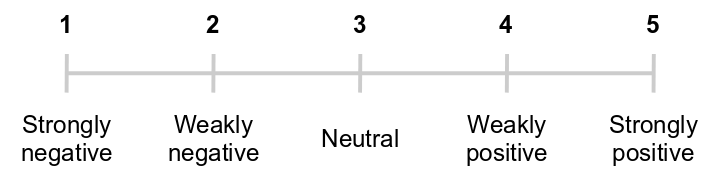

In [121]:
# Bin edges that will be used to "cut" the data into groups
bin_edges = [-1.0,-0.5,-0.001,0.001,0.5,1]

# Labels for the sentiments
bin_names = ['Strongly negative', 'Weakly negative', 'neutral', 'Weakly positive', 'Strongly positive']

# Creates acidity_levels column
df['polarity_sentiment'] = pd.cut(df['polarity'].astype(float), bin_edges, labels=bin_names)

# Checks for successful creation of this column
df.head()

,user_id,Text,created_at,timestamp,location,latitude,longitude,country,country_code,followers_count,hashtags,polarity,subjectivity,polarity_sentiment
1.26434E+18,8.20915E+17,@rhynneigh871998 covid... charot haha,Sat May 23 23:28:18 +0000 2020,1590269298,Las Encinas,25.6484902,-101.1229491,México,,383,,0.2,0.3,Weakly positive
1.26434E+18,81227663,"RT @PaulbernalUK: Ppl, the story of Cummings b...",Sat May 23 23:28:18 +0000 2020,1590269298,"London, England",51.5073219,-0.1276474,United Kingdom,GBR,1786,,0,0.12,neutral
1.26434E+18,9.66135E+17,40-Second Full-Body Sanitizing Booth #COVID19 ...,Sat May 23 23:28:18 +0000 2020,1590269298,"Southfield, Michigan",42.4733689,-83.2218731,United States of America,USA,363,#COVID19,0,0,neutral
1.26434E+18,8.20915E+17,@rhynneigh871998 covid... charot haha,Sat May 23 23:28:18 +0000 2020,1590269298,Las Encinas,25.6484902,-101.1229491,México,,383,,0.2,0.3,Weakly positive
1.26434E+18,81227663,"RT @PaulbernalUK: Ppl, the story of Cummings b...",Sat May 23 23:28:18 +0000 2020,1590269298,"London, England",51.5073219,-0.1276474,United Kingdom,GBR,1786,,0,0.12,neutral


<class 'set'>
<class 'list'>


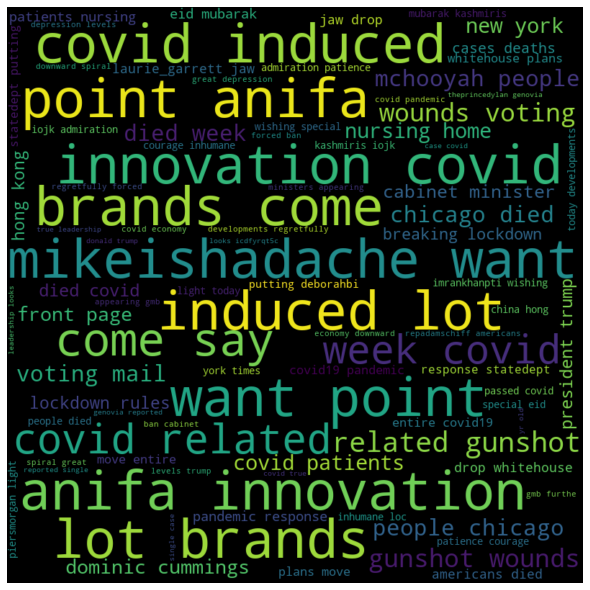

In [91]:
comment_words = '' 
print(type(STOPWORDS))

stop_words = list(stopwords.words('english'))  
stop_words = stop_words + list(STOPWORDS) 

stop_words = ["co", "RT","http", "https", "rt", "amp", "etc"] + stop_words 

print(type(stop_words))
# iterate through the csv file 
# Text

for val in df.Text: 
# typecaste each val to string 
    val = str(val) 

    # split the value 
    tokens = val.split() 
    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 

# store to file
#WordCloud.to_file("img/first_review.png")
wordcloud.to_file("word_cloud.png")

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

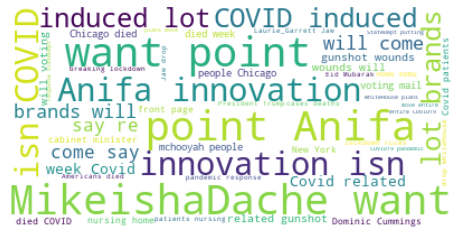

In [106]:
# form one text variable with all dog_breeds
text = " ".join(str(text) for text in df.Text)

stopwords = set(STOPWORDS)
stopwords.update(["nan","co", "RT","http", "https", "rt", "amp", "etc"])

  
#stopwords = stopwords + list(STOPWORDS) 

#stopwords = ["co", "RT","http", "https", "rt", "amp", "etc"] + stopwords 


# Generate a word cloud image
wc = WordCloud(max_font_size=100, max_words=50, stopwords = stopwords,background_color="white").generate(text)

# store to file
wc.to_file("word_cloud2.png")

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Hashtags wordcloud
What are the hashtags that are being used with the COVID19 related data?

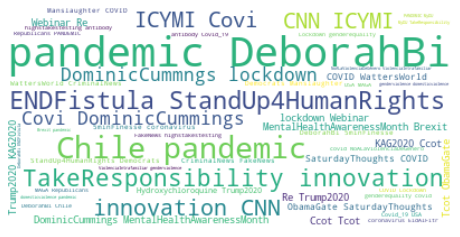

In [114]:
## All hashtags

# form one text variable with all dog_breeds
text = "".join(str(hashtags).replace("ー", "") for hashtags in df.hashtags)
text = text.replace("#"," ")

stopwords = set(STOPWORDS)
stopwords.update(["nan","co", "RT","http", "https", "rt", "amp", "etc","COVID19"])

  
#stopwords = stopwords + list(STOPWORDS) 

#stopwords = ["co", "RT","http", "https", "rt", "amp", "etc"] + stopwords 


# Generate a word cloud image
wc = WordCloud(max_font_size=100, max_words=50, stopwords = stopwords,background_color="white").generate(text)

# store to file
wc.to_file("word_cloud3.png")

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

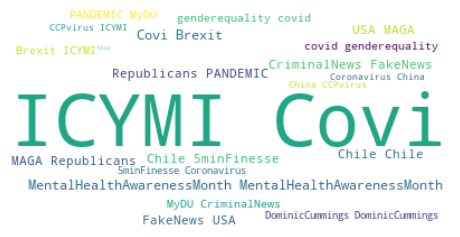

In [127]:
## only positive hashtags

# form one text variable with all dog_breeds
text = "".join(str(hashtags).replace("ー", "") for hashtags in df['hashtags'][df['polarity_sentiment'] == 'Strongly positive'])
text += "".join(str(hashtags).replace("ー", "") for hashtags in df['hashtags'][df['polarity_sentiment'] == 'Weakly positive'])
text = text.replace("#"," ")

stopwords = set(STOPWORDS)
stopwords.update(["nan","co", "RT","http", "https", "rt", "amp", "etc","COVID19"])

  
#stopwords = stopwords + list(STOPWORDS) 

#stopwords = ["co", "RT","http", "https", "rt", "amp", "etc"] + stopwords 


# Generate a word cloud image
wc = WordCloud(max_font_size=100, max_words=500, stopwords = stopwords,background_color="white").generate(text)

# store to file
wc.to_file("word_cloud3.png")

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

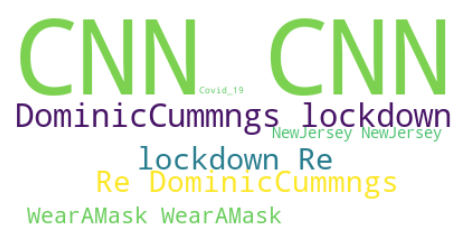

In [128]:
## only negative hashtags
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline


# form one text variable with all dog_breeds
text = "".join(str(hashtags).replace("ー", "") for hashtags in df['hashtags'][df['polarity_sentiment'] == 'Strongly negative'])
text += "".join(str(hashtags).replace("ー", "") for hashtags in df['hashtags'][df['polarity_sentiment'] == 'Weakly negative'])
text = text.replace("#"," ")

stopwords = set(STOPWORDS)
stopwords.update(["nan","co", "RT","http", "https", "rt", "amp", "etc","COVID19"])

  
#stopwords = stopwords + list(STOPWORDS) 

#stopwords = ["co", "RT","http", "https", "rt", "amp", "etc"] + stopwords 


# Generate a word cloud image
wc = WordCloud(max_font_size=100, max_words=500, stopwords = stopwords,background_color="white").generate(text)

# store to file
wc.to_file("word_cloud3.png")

# show
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### sentiment analysis

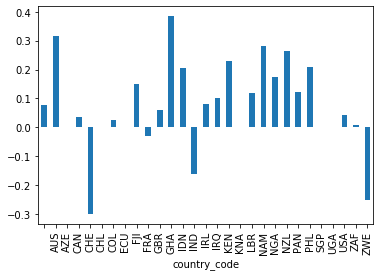

In [170]:
df['polarity'].groupby(df['country_code']).mean().plot(kind='bar');


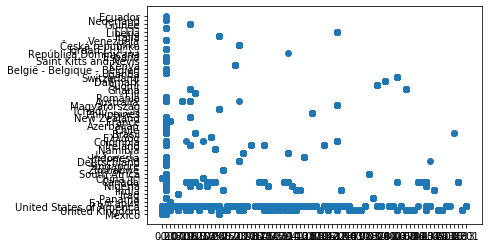

In [161]:

plt.scatter(y = df['country'], x = df['polarity']);

In [72]:
header_name = ['id', 'user_id','Text','created_at','timestamp','location','latitude','longitude','country',
               'country_code','followers_count','hashtags','polarity','subjectivity']




In [7]:
pycountry.countries.get(alpha_2='DE')

Country(alpha_2='DE', alpha_3='DEU', name='Germany', numeric='276', official_name='Federal Republic of Germany')